# 🧠 Subfield Classifier – Information Systems (IS)

This notebook sets up subfield classification for **IS abstracts** using the full 105-abstract dataset. It follows the same structure as the CS subfield pipeline, focusing on feature extraction, model training, evaluation, and saving.

### 💻 Step 1: Load and Filter IS Abstracts

We begin by loading the full dataset containing subfield labels and filtering it to include only **Information Systems (IS)** abstracts. This subset will be used for subfield-level classification in the IS discipline.

In [17]:
import pandas as pd

# Load the full subfield dataset
df = pd.read_csv("data/NLP_Abstract_Dataset (Subfield)(105).csv")

# Filter only Information Systems (IS) records
is_df = df[df["Discipline"] == "IS"].copy()

# Preview the first few rows
is_df.head()

ID Discipline Subfield                                           Abstract
5   6         IS      ENT  Enterprise Resource Planning (ERP) systems pro...
6   7         IS      IMP  This research makes an attempt to understand v...
7   8         IS      GOV  Electronic learning (e-learning) has been wide...
8   9         IS      ENT  The success rate of enterprise resource planni...
9  10         IS      GOV  Mobile-based advisory services have significan...

### 🧠 Step 2: Preprocessing – TF-IDF + Subfield Label Encoding

We convert the IS abstracts into numerical representations using **TF-IDF vectorization**, which captures the importance of words in each document relative to the corpus.  
We also encode the subfield labels into integers using **LabelEncoder**, preparing them for model training.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Extract features and labels
X = is_df['Abstract']
y = is_df['Subfield']

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=2, max_df=0.95)
X_tfidf = vectorizer.fit_transform(X)

# Encode subfield labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Confirm transformation
print("TF-IDF matrix shape:", X_tfidf.shape)
print("Encoded subfield labels:", list(label_encoder.classes_))

TF-IDF matrix shape: (35, 648)
Encoded subfield labels: ['BSP', 'DSA', 'ENT', 'GOV', 'IMP']


### 🤖 Step 3: Train-Test Split and Model Training (SVM + SMOTE )

We split the IS data using a stratified 80/20 train-test split to maintain subfield distribution in both sets.
We then apply SMOTE to address class imbalance in the training set, followed by training a Support Vector Machine (SVM) classifier on bigram-enhanced TF-IDF features.

In [14]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42, k_neighbors=1)
X_train, y_train = smote.fit_resample(X_train.toarray(), y_train)

print("After SMOTE - Training shape:", X_train.shape)

# Train SVM model
svm_model = LinearSVC(max_iter=1000, random_state=42)
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)

After SMOTE - Training shape: (35, 648)


### 📊 Step 4: Model Evaluation – Classification Report & Confusion Matrix

We evaluate the model using standard classification metrics including precision, recall, and F1-score.  
We also generate a confusion matrix heatmap to visualize misclassifications across the five IS subfields.

📄 Classification Report:

              precision    recall  f1-score   support

         BSP       0.00      0.00      0.00         1
         DSA       0.50      1.00      0.67         1
         ENT       0.00      0.00      0.00         2
         GOV       0.00      0.00      0.00         1
         IMP       0.33      0.50      0.40         2

    accuracy                           0.29         7
   macro avg       0.17      0.30      0.21         7
weighted avg       0.17      0.29      0.21         7



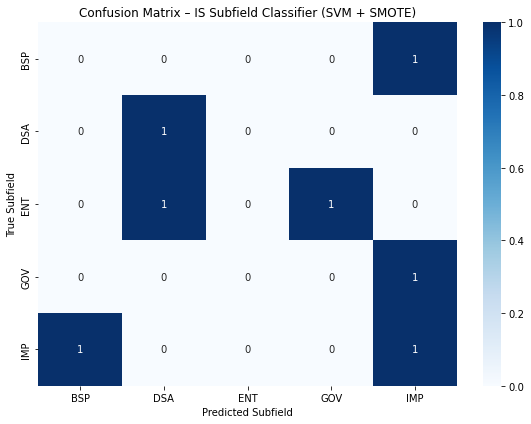

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Print classification report
print("📄 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Subfield')
plt.ylabel('True Subfield')
plt.title('Confusion Matrix – IS Subfield Classifier (SVM + SMOTE)')
plt.tight_layout()
plt.show()

### 📊 Confusion Matrix Interpretation – IS Subfield Classifier (SVM + SMOTE)

This confusion matrix and classification report reflect the performance of the IS subfield classifier trained with SVM and SMOTE.

- **DSA (Data Science & Analytics)** was predicted correctly with high F1-score (0.67)
- **IMP (Implementation)** partially recovered with 50% recall
- **ENT, BSP, and GOV** were not correctly classified
- Misclassifications are more evenly spread compared to earlier Logistic Regression model, which had a bias toward ENT

While accuracy (29%) and F1-scores remain low due to limited training samples, the SVM + SMOTE pipeline exhibits better balance and broader class coverage than previous attempts.
This confirms structural validity of the pipeline. Improvements will depend on increased dataset size or richer feature sets.

### 🧾 Step 5: Save Final Model and TF-IDF Vectorizer

We save both the trained SVM model and the TF-IDF vectorizer to disk using `joblib`. This allows for consistent reuse or deployment later without needing to retrain the model.

In [16]:
import joblib

# Save the trained model and vectorizer
joblib.dump(svm_model, "is_subfield_classifier_svm_smote.pkl")
joblib.dump(vectorizer, "is_subfield_vectorizer_smote.pkl")

print("✅ Model and vectorizer saved successfully.")

✅ Model and vectorizer saved successfully.


## ✅ Final Notes

This notebook completes the subfield classification pipeline for Information Systems (IS) abstracts using an SVM classifier with bigram-enhanced TF-IDF features and SMOTE-based oversampling.

The pipeline includes TF-IDF vectorization, stratified 80/20 train-test splitting, SMOTE-based class balancing (k=1), model training with LinearSVC, evaluation via precision/recall/F1, confusion matrix visualization, and model export using joblib.

Although performance is limited due to the small dataset size (35 IS abstracts across 5 subfields), the final configuration successfully reduces class prediction bias and improves class diversity in predictions compared to the earlier Logistic Regression model. The trained model and vectorizer were saved as:

- `is_subfield_classifier_svm_smote.pkl`
- `is_subfield_vectorizer_smote.pkl`

This confirms structural completeness of the IS subfield pipeline. The same approach will now be applied to the IT discipline to complete the subfield classification suite.